#### Supplementary Information: Holmes *et al.* 2017

# 11. An unpooled model

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

Here, we treat each probe again as if the measured log *output* intensity is a linear function only of the log *input* intensity as a predictor. However, we now fit a linear relationship for each *locus_tag*.

We construct the following model of the experiment:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \epsilon_i$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *probe ID*
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique probe IDs (`J` < `N`)
* `tag`: `int[N]`, an index list of probe identities - one index representing six probe measurements (i.e. three control, three treatment) - there are `J` probes
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, representative input log(intensity)
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a probe ID
* `sigma`: `real<lower=0>`, the error in the prediction

We also define a `transformed parameter`:

* `y_hat[i] <- b[probe[i]] * x[i] + a[probe[i]]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as $y \sim N(\hat{y}, \sigma^2)$.

In [3]:
# load clean, normalised, indexed data
# data = pd.read_csv("output/normalised_array_data.tab", sep="\t")  # full dataset
data = pd.read_csv("output/reduced_normalised_locus_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
tag_ids = data['locus_tag'].unique()
ntags = len(tag_ids)

In [4]:
# define unpooled stan model
unpooled_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> tag[N];
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  real<lower=0> sigma;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[tag[i]] + b[tag[i]] * x[i];
}
model {
  y ~ normal(y_hat, sigma);
}
"""

In [6]:
# relate python variables to stan variables
unpooled_data_dict = {'N': len(data),
                      'J': nprobes,
                      'tag': data['locus_index'] + 1,
                      'x': data['log_input'],
                      'y': data['log_output']}

In [7]:
# run stan fit
unpooled_fit = pystan.stan(model_code=unpooled_model,
                           data=unpooled_data_dict,
                           iter=1000, chains=2,
                           seed=tools.SEED)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3d7fc179fea7cf91abbbe877007bc356 NOW.


In [8]:
# Save model to file, for reuse# Save fit to file, for reuse
unpermutedChains = unpooled_fit.extract()

unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
pickle.dump(unpermutedChains_df, open('output/2016-12-05_notebook11.pkl', 'wb'))

## Inspecting the fit

In [9]:
# Get fits to alpha and beta by probe ID
alpha_estimates = pd.Series(unpooled_fit['a'].mean(0), index=probe_ids)
alpha_se = pd.Series(unpooled_fit['a'].std(0), index=probe_ids)
beta_estimates = pd.Series(unpooled_fit['b'].mean(0), index=probe_ids)
beta_se = pd.Series(unpooled_fit['b'].std(0), index=probe_ids)

In [10]:
# Inspect the estimates
alpha_estimates.head()

ECs1176    1.085096
ECs2998    0.724664
ECs2996    0.885256
ECs2983    0.785828
ECs2974    1.199622
dtype: float64

In [11]:
# Inspect the estimates
beta_estimates.head()

ECs1176    0.220019
ECs2998    0.453534
ECs2996    0.337684
ECs2983    0.338945
ECs2974    0.381973
dtype: float64

### Intercept $\alpha_{j[i]}$

Taking the intercept first, we can get an overview of the mean and standard error of $\alpha$:

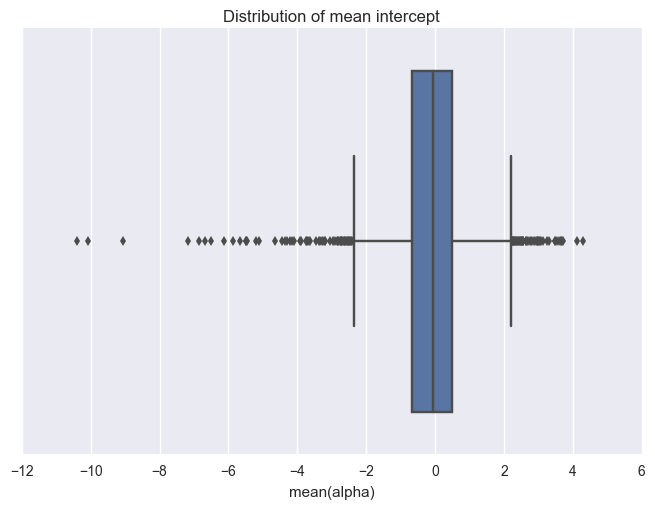

In [12]:
# Plot means distribution
g = sns.boxplot(alpha_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(alpha)");

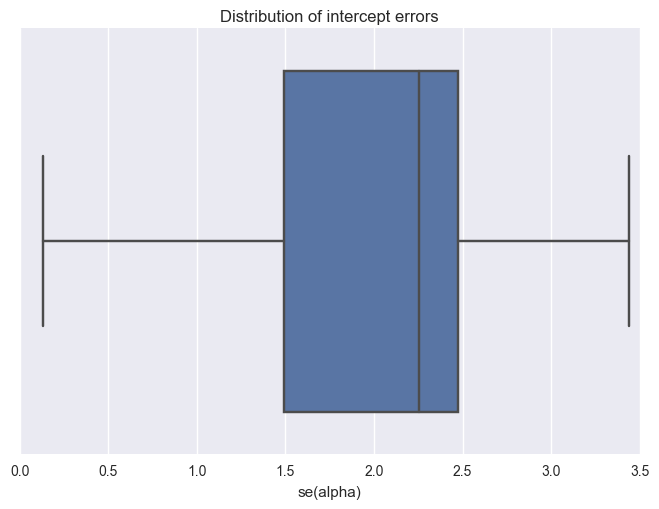

In [13]:
# Plot error distribution
g = sns.boxplot(alpha_se)
g.set_title("Distribution of intercept errors")
g.set_xlabel("se(alpha)");

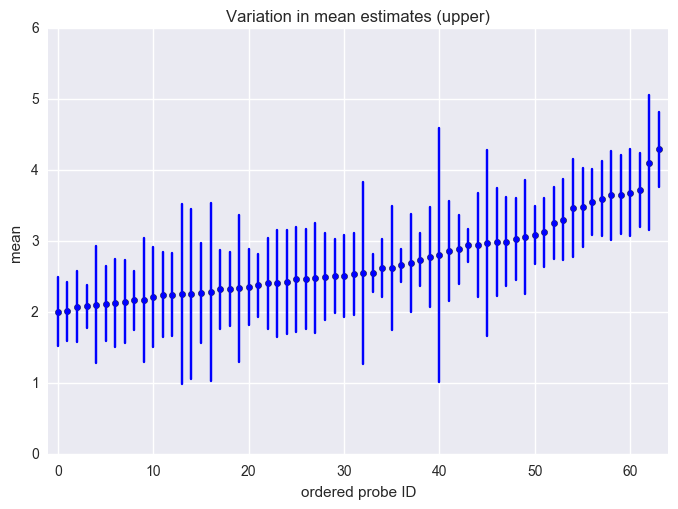

In [16]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, 2)

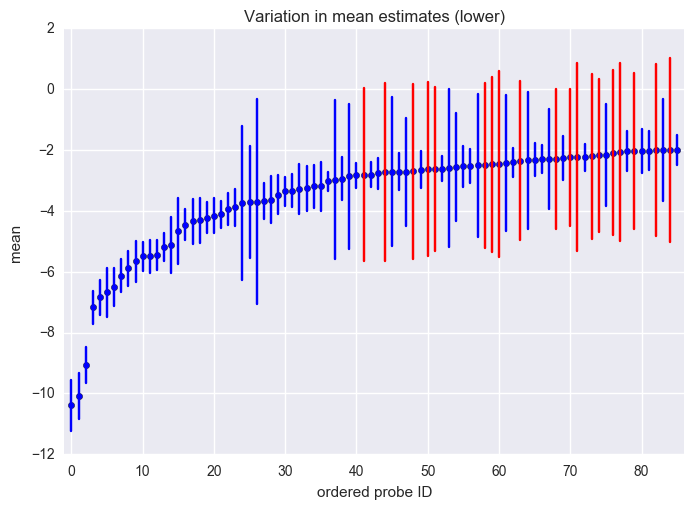

In [17]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, -2, upper=False)

### Slopes $\beta_{j[i]}$

The variation of slopes $\beta_{j[i]}$ by *probe ID* are the most interesting estimates, as they are indicative of the way *output* intensity measurements depend on *input* intensity measurements, and could help identify genes that are advantageous or disadvantageous in our experiment.

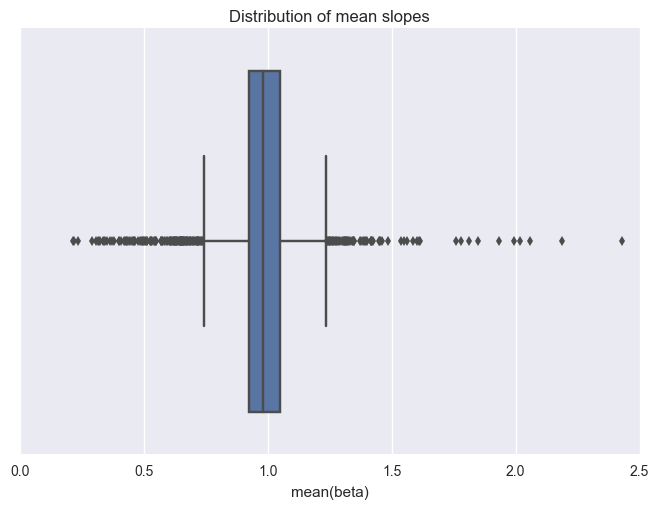

In [18]:
# Plot distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean slopes")
g.set_xlabel("mean(beta)");

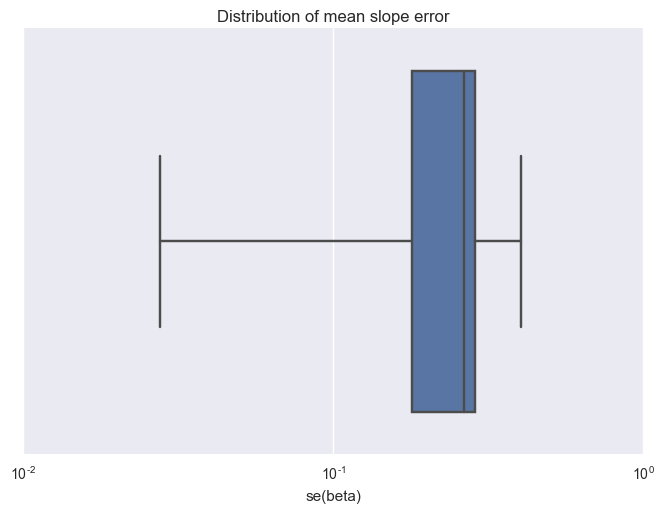

In [19]:
# Plot distribution
g = sns.boxplot(beta_se)
g.set_title("Distribution of mean slope error")
g.set_xscale("log")
g.set_xlabel("se(beta)");

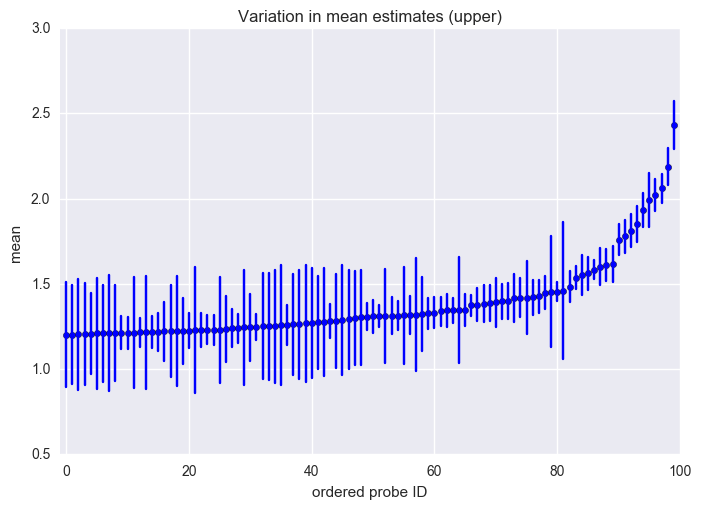

In [20]:
# plot all errors/means
tools.plot_threshold_errors(beta_estimates, beta_se, 1.2)

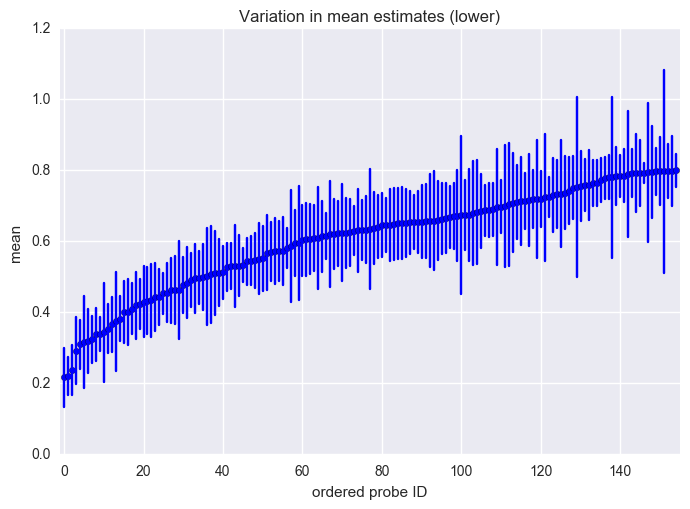

In [21]:
# plot all errors/means
tools.plot_threshold_errors(beta_estimates, beta_se, 0.8, upper=False)

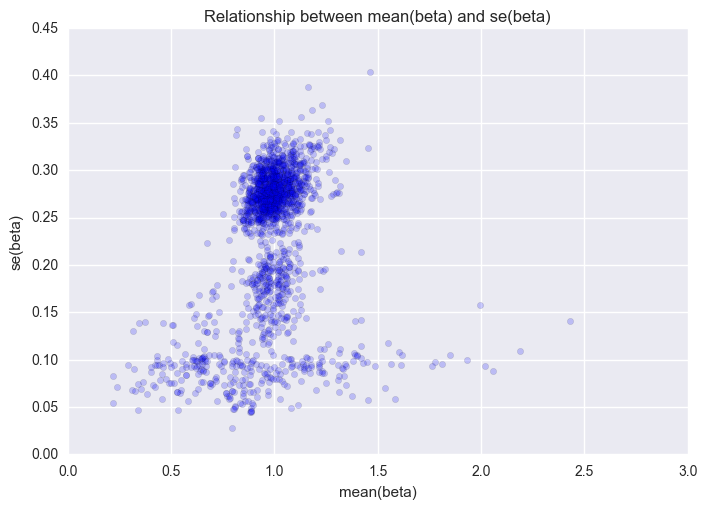

In [22]:
# How does estimate of error relate to error in the estimate
plt.scatter(beta_estimates, beta_se, alpha=0.2)
plt.title("Relationship between mean(beta) and se(beta)")
plt.xlabel("mean(beta)")
plt.ylabel("se(beta)");

In [32]:
def df_add_coefficient(data, coeff_name, means, errors, index_column):
    df = pd.DataFrame({'{0}_mean'.format(coeff_name): means,
                       '{0}_error'.format(coeff_name): errors})
    df.reset_index(inplace=True)
    df = df.rename(columns={'index': index_column})
    df = pd.merge(data, df, 'inner', [index_column])
    return df

In [33]:
df_beta = tools.df_add_coefficient(data, 'b', beta_estimates, beta_se, 'locus_tag')

In [36]:
df_beta.head()

,dh10b_match,input,locus_tag,log_input,log_output,match,output,probe,replicate,sakai_match,treatment,probe_index,locus_index,b_error,b_mean
0,0.0,13.354233,ECs1176,2.591833,2.352119,lcl|NC_002695.1_cds_NP_309203.1_1134,10.507812,A_07_P052986,1,1,0,0,0,0.053859,0.220019
1,0.0,6.815142,ECs1176,1.919147,2.431403,lcl|NC_002695.1_cds_NP_309203.1_1134,11.374824,A_07_P052986,2,1,0,0,0,0.053859,0.220019
2,0.0,146.893973,ECs1176,4.989711,2.125809,lcl|NC_002695.1_cds_NP_309203.1_1134,8.379672,A_07_P052986,3,1,0,0,0,0.053859,0.220019
3,0.0,0.629964,ECs1176,-0.462092,0.878914,lcl|NC_002695.1_cds_NP_309203.1_1134,2.408282,A_07_P052986,1,1,1,0,0,0.053859,0.220019
4,0.0,0.651612,ECs1176,-0.428306,1.853818,lcl|NC_002695.1_cds_NP_309203.1_1134,6.384148,A_07_P052986,2,1,1,0,0,0.053859,0.220019


In [58]:
sorted(df_beta.loc[df_beta['b_mean'] < 0.5]['locus_tag'].unique())

['ECs0336',
 'ECs0350',
 'ECs1074',
 'ECs1176',
 'ECs1262',
 'ECs1280',
 'ECs1282',
 'ECs1283',
 'ECs1286',
 'ECs1287',
 'ECs1295',
 'ECs1315',
 'ECs1321',
 'ECs1325',
 'ECs1340',
 'ECs1344',
 'ECs1345',
 'ECs1355',
 'ECs1906',
 'ECs2060',
 'ECs2631',
 'ECs2632',
 'ECs2635',
 'ECs2974',
 'ECs2983',
 'ECs2984',
 'ECs2996',
 'ECs2998',
 'ECs3010',
 'ECs3012',
 'ECs3028',
 'ECs4951',
 'ECs4952',
 'ECs4965',
 'ECs4967',
 'ECs4974']

In [55]:
df = pd.DataFrame({'mean': beta_estimates,
                   'error': beta_se})
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'locus_tag'})
df.sort_values('locus_tag', inplace=True)
df.head()

,locus_tag,error,mean
1181,ECDH10B_RS00030,0.147178,0.951834
1678,ECDH10B_RS00035,0.303037,1.079253
1677,ECDH10B_RS00040,0.244640,1.065999
1674,ECDH10B_RS00065,0.281007,1.020000
1093,ECDH10B_RS00080,0.198863,0.955488


(0, 1790)

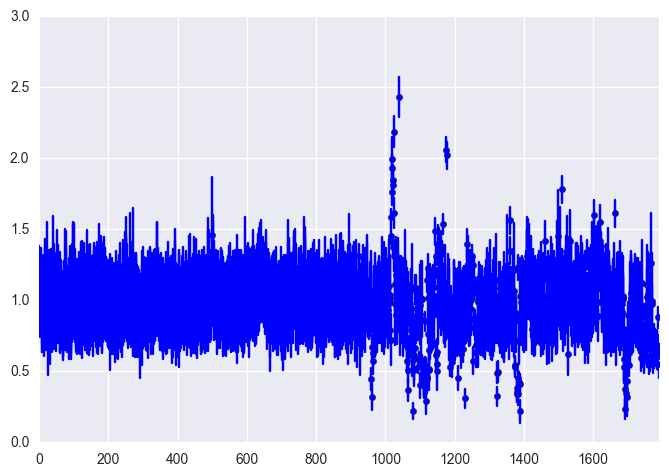

In [56]:
# plot ordered means and errors
plt.scatter(range(len(df)), df['mean'])
for idx, mn, se in zip(range(len(df)),
                       df['mean'], df['error']):
    if se > abs(mn):
        color = 'r-'
    else:
        color = 'b-'
    plt.plot([idx, idx], [mn - se, mn + se], color)
plt.xlim(0, len(beta_estimates))